In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import scipy
from scipy.optimize import curve_fit

import functions as fnc

# Characteristic Matrices

Die Transfermatrix, die ich aus Astra bekomme will ich vergleichen mit einer theoretischen. Grund dafür ist, dass ich dann zum Beispiel

- Abbildungspunkt
- $delta$ = fractional momentum = Impulsverteilung 

bestimmen kann.

Ein Elektron hat folgende transversale Position aus dem Screen am Ende:

$x = R_{11} x_0 + R_{12} x_0' + R_{16} \delta$,

da die Transformationsmatrix ganz allgemein so aussieht:

$\vec{v_f} = \begin{pmatrix}
    R_{11} & R_{12} & R_{13} & R_{14} & R_{15} & R_{16}\\
    R_{21} & R_{22} & R_{23} & R_{24} & R_{25} & R_{26}\\
    R_{31} & R_{32} & R_{33} & R_{34} & R_{35} & R_{36}\\
    R_{41} & R_{42} & R_{43} & R_{44} & R_{45} & R_{46}\\
    R_{51} & R_{52} & R_{53} & R_{54} & R_{55} & R_{56}\\
    R_{61} & R_{62} & R_{63} & R_{64} & R_{65} & R_{66}\\
  \end{pmatrix}
  \cdot 
  \begin{pmatrix}
    x_0 \\
    x_0' \\
    y_0 \\
    y_0' \\
    l \\
    \delta \\
  \end{pmatrix}
  $
  
Ein paar dieser Eintrage sollen aber null werden, da zum Beispiel x und y nicht koppeln:

$\vec{v_f} = \begin{pmatrix}
    R_{11} & R_{12} & 0 & 0 & 0 & R_{16}\\
    R_{21} & R_{22} & 0 & 0 & 0 & R_{26}\\
    0 & 0 & R_{33} & R_{34} & 0 & 0\\
    0 & 0 & R_{43} & R_{44} & 0 & 0\\
    R_{51} & R_{52} & 0 & 0 & 1 & R_{56}\\
    0 & 0 & 0 & 0 & 0 & 1\\
  \end{pmatrix}
  \cdot 
  \begin{pmatrix}
    x_0 \\
    x_0' \\
    y_0 \\
    y_0' \\
    l \\
    \delta \\
  \end{pmatrix}
  $
 
 
Mit 
- $x$ - radiale Ortsabweichung
- $x'$ - radiale Richtungsabweichung
- $y$ - axiale Ortsabweichung
- $y'$ - axiale Richtungsabweichung
- $l$ - longitudinale Ortsabweichung
- $\delta$ - ralative Impulsabweichung
  
Ich muss folgende Punkte noch bedenken:

- meine erste Driftstrecke ist nicht die Strecke zwischen Start des Koordinatensystems und dem Dipol. In dieser Zeit sind die Elektronen ja schon längst auseinander geflogen. Ich brauche die Länge zwischen Fokuspunkt und Dipolanfang, bzw. zwischen Schlitz und Dipolanfang. Diese nenne ich erst einmal $l_0$.


Rechne zunächst die drei wichtigen Elemente einzeln aus, nach dem Skript, was ich bekommen habe:
  

In [23]:
L1, L2, gamma, theta, rho, psi = sp.symbols('L_1, L_2, gamma, theta, rho, psi')


In [24]:
Leff, uLeff =[335.20640620395164, 0.2958181993066121] #mm from other file (B an Trajektorie)

l1 = np.cos(30 / 180 * np.pi) * Leff / 2 # effective legnth projected onto z axis
l2 = 1 / np.cos(30 / 180 * np.pi)  * Leff / 2 # effecticve length projected onto outgoing axis

CentreDipole = np.array([1854, 116]) # in coordinate system C
L1 = CentreDipole[0] - l1

lambda2 = 824.2/np.sin(60/180 * np.pi)

L2 = lambda2 - l2

L1, L2 # all in mm

# convert to m
L1 = L1 / 1000
L2 = L2 / 1000
Leff = Leff / 1000
L1, L2, Leff

(1.7088513683580462, 0.7581726748762407, 0.33520640620395165)

In [25]:
theta =  - 60 * np.pi / 180 #     Ablenkwinkel des Magneten 
psi = -16.1 * np.pi / 180 # Kantenwinkel (MAD definition)

rho = Leff / np.sin(theta)
urho = np.sqrt((1/np.sin(theta) * uLeff)**2)

# p in MeV/c
c = 1
m0 = 0.51099895000 #MeV/c^2
gamma = np.sqrt(1 + (6 /(m0 * c))**2)
print(gamma)


11.784213408370235


- z in Bewegungsrichtung vor Dipol
- s in Bewegungsrichtung des Strahls
- x in Strahlrichtung nach links 
    - ist x immer im System des Referenzteilchens? Wenn ja, dann habe ich mein x bis jetzt ja immer falsch gewählt...
- y nach oben 
- $\rho$ ist positiv, wenn ablenkung in Strahlrichtung nach rechts erfolgt 

Im folgenden berechne ich die Transformationsmatrix über Matrixmultiplikation:

In [26]:
DriftVor = sp.Matrix([[1, L1, 0, 0, 0, 0], 
                   [0, 1, 0, 0, 0, 0], 
                   [0, 0, 1, L1, 0, 0], 
                   [0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, (L1)/(gamma**2)], 
                   [0, 0, 0, 0, 0, 1]])

DriftNach = sp.Matrix([[1, L2, 0, 0, 0, 0], 
                   [0, 1, 0, 0, 0, 0], 
                   [0, 0, 1, L2, 0, 0], 
                   [0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, (L2)/(gamma**2)], 
                   [0, 0, 0, 0, 0, 1]])

Dipol = sp.Matrix([[sp.cos(theta), rho * sp.sin(theta), 0, 0, 0, rho * (1-sp.cos(theta))],
                  [-sp.sin(theta) / rho, sp.cos(theta), 0, 0, 0, sp.sin(theta)],
                  [0, 0, 1, rho * theta, 0, 0],
                  [0, 0, 0, 1, 0, 0],
                  [-sp.sin(theta), -rho * (1-sp.cos(theta)), 0, 0, 1, rho * theta / (gamma**2) - rho * (theta - sp.sin(theta))],
                  [0, 0, 0, 0, 0, 1]])

KanteVor = sp.Matrix([[1, 0, 0, 0, 0, 0],
                  [sp.tan(psi) / rho, 1, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 0, -sp.tan(psi) / rho, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])

KanteNach = sp.Matrix([[1, 0, 0, 0, 0, 0],
                  [sp.tan(psi) / rho, 1, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 0, -sp.tan(psi) / rho, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])



TrafoMatrix = DriftNach * KanteNach  * Dipol * KanteVor * DriftVor
display(TrafoMatrix)

print("Sanity Check: Determinante muss 1 sein.")
print(f"det(M) = {TrafoMatrix.det()}")


Matrix([
[-0.239693222861818, 0.494209579049132,                  0,                 0, 0,  -0.959545954735424],
[ -1.30532086453266, -1.48063395693027,                  0,                 0, 0,   -1.01034298816496],
[                 0,                 0, -0.262116902774643, 0.486421503064512, 0,                   0],
[                 0,                 0,  -1.26601616315905, -1.46569149469354, 0,                   0],
[  1.01034298816496,   1.9200575066926,                  0,                 0, 1, -0.0494409208869888],
[                 0,                 0,                  0,                 0, 0,                   1]])

Sanity Check: Determinante muss 1 sein.
det(M) = 1.00000000000000


In [27]:
test = np.array(TrafoMatrix)
TrafoRounded = np.zeros(36).reshape(6,6)


for i in range(6):
    for j in range(6):
        TrafoRounded[i][j] = fnc.properRound(test[i][j], 5)
        
sp.Matrix(TrafoRounded)

Matrix([
[ -0.2397,  0.49421,      0.0,     0.0, 0.0, -0.95955],
[-1.30533, -1.48064,      0.0,     0.0, 0.0, -1.01035],
[     0.0,      0.0, -0.26212, 0.48642, 0.0,      0.0],
[     0.0,      0.0, -1.26602, -1.4657, 0.0,      0.0],
[ 1.01034,  1.92006,      0.0,     0.0, 1.0, -0.04945],
[     0.0,      0.0,      0.0,     0.0, 0.0,      1.0]])

Im nächsten Schritt will ich diese Matrix vergleichen mit der, welche ich aus Astra bekomme. Dafür erstelle ich zunächst einmal eine Verteilung von Teilchen:

Alles dargestellte hier sind x-px-Paare, aber diese kommen teilweise durch initiale y, py, z, pz Werte.


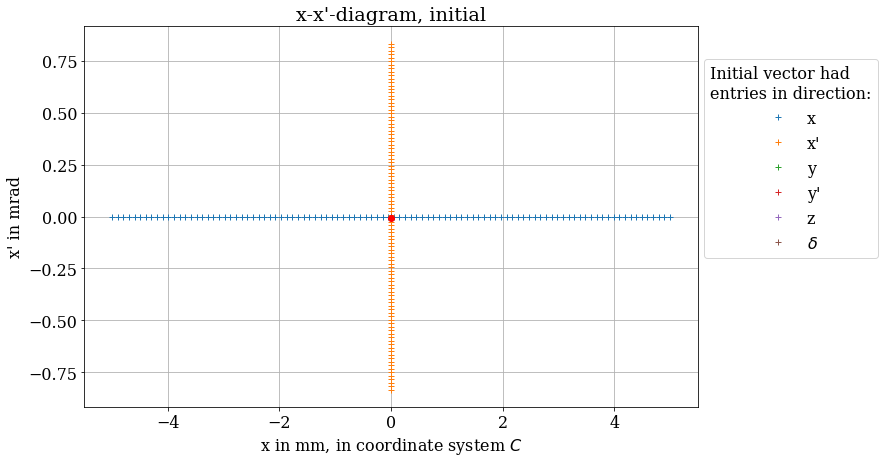

In [28]:
# -------------- ERSTELLEN DER WERTE --------------

array = np.array([np.zeros(601).tolist() for i in range(10)]) # erschaffe array mit 10 Spalten und je 601 Einträgen 
# darin sind je 100er blöcke von gleichen Ausgangssituationen 

array[0][1:101]   = np.linspace(-5e-3, 5e-3, 100)  # Vektor hat erste   100 Werte: x von -5 bis 5 mm
array[3][101:201] = np.linspace(-5e3, 5e3, 100)    # Vektor hat zweite  100 Werte: px von -5 bis 5 keV/c
array[1][201:301] = np.linspace(-1e-3, 1e-3, 100)   # 100 Werte: y von -1 bis 1 mm
array[4][301:401] = np.linspace(-1e3, 1e3, 100)     # 100 Werte: py von -1 bis 1 keV/c
array[2][401:501] = np.linspace(-3e-3, 3e-3, 100)   # 100 Werte: z von -3 bis 3 mm
array[5][501:601] = np.linspace(-3e3, 3e3, 100)     # 100 Werte: pz von -3 bis 3 keV/c

# Lege Energie des Referenzteilchens fest
prefi = np.transpose(array)[0][5] = 6e6 #6 MeV/c

# Die Relativkoordinaten zur Beschreibung der Teilchen 
# so verstehe ich gerade die Beschreibung im Buch. x, y, z sind relativ zum Teilchen.
# Dann bewegt sich aber ständig auch ein Winkel mit. Das kann doch nicht richtig sein?

# Seite 119 im Hinterberger. 
# Daher muss ich dann bei den finalen Werten das System drehen - oder?


#Lege für Astra noch die anderen Spalten fest:
array[-1] = 5 #alle kriegen Status Flag 5
for i in range(6):
    array[-1][i*100 + 1] = 3 # das erste Teilchen jeder Art kriegt ne 3

array[-2] = 1 #Particle
array[-3] = 1e-7 #10^-7 nC Charge 


Array = np.transpose(array)
np.savetxt("Dipole.ini", Array)  # speichere direkt, dass nur noch Astra auszuführen ist


xi = array[0].copy()  # x, y und z sind immer relativ zum Teilchen beschrieben.
yi = array[1].copy()
zi = array[2].copy() 
zi[1:601] = zi[1:601] + zi[0]   # z Werte waren ja nur relativ zu zRef angegeben. Brauche die natürlich in meinem Bezugssystem!

pxi = array[3].copy()
pyi = array[4].copy()
pzi = array[5].copy()
pzi[1:601] = pzi[1:601] + pzi[0]


xiDash = pxi / pzi
yiDash = pyi / pzi
deltai = (pzi - prefi) / prefi

plt.rcParams['figure.figsize'] = (11, 7)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.plot(xi[1:101] * 1000, pxi[1:101] / prefi * 1000, "+", label = "x")
plt.plot(xi[101:201] * 1000, pxi[101:201] / prefi * 1000, "+", label = "x'")
plt.plot(xi[201:301] * 1000, pxi[201:301] / prefi * 1000, "+", label = "y")
plt.plot(xi[301:401] * 1000, pxi[301:401] / prefi * 1000, "+", label = "y'")
plt.plot(xi[401:501] * 1000, pxi[401:501] / prefi * 1000, "+", label = "z")
plt.plot(xi[501:601] * 1000, pxi[501:601] / prefi * 1000, "+", label = "$\delta$")
plt.plot(array[0][0] * 1000, array[0][3], "ro")
plt.xlabel("x in mm, in coordinate system $C$")
plt.ylabel("x' in mrad")
plt.title("x-x'-diagram, initial")
plt.legend(loc = [1.01, 0.39], title = "Initial vector had \nentries in direction:")
plt.grid()
print("Alles dargestellte hier sind x-px-Paare, aber diese kommen teilweise durch initiale y, py, z, pz Werte.")
plt.savefig(f"InitialDistribution.svg", format='svg', dpi=1000, bbox_inches='tight')
plt.show()

In [29]:
vectorInitial = np.array([xi, xiDash, yi, yiDash, zi, deltai])
finalerVektorTheo = np.array(TrafoMatrix) @ vectorInitial

# versuche den richtigen x fest Wert zu berechnen. Details in meiner Datei.
zfTheo = finalerVektorTheo[4]

# zneu ist die Strecke zwischen Schirm und der Achse, die dann die ursprüngliche z-Achse schneidet.
zneu = 824.5 / np.sin(60 * np.pi / 180) / 1000 # m

x = finalerVektorTheo[0]
z = finalerVektorTheo[4]

# für jedes verschoebene Elektron hat das ganze aber sowohl einen anderen Winkel, als auch eine andere Länge.
# das ist mein Ding für morgen.

xAblage = x * np.sin(30 / 180 * np.pi)
zAblage = z * np.cos(30 / 180 * np.pi)

xFestesSystem = xAblage + 824.5 / 1000


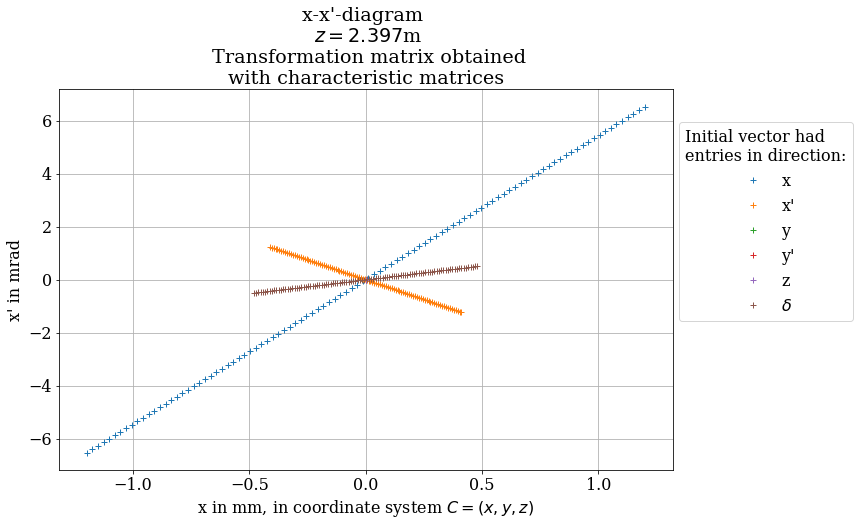

In [30]:
vectorInitial = np.array([xi, xiDash, yi, yiDash, zi, deltai])
finalerVektorTheo = np.array(TrafoMatrix) @ vectorInitial
def plotTheo(finalerVektorTheo):

    xfTheo = finalerVektorTheo[0] 
    xfDashTheo = finalerVektorTheo[1]
    yfTheo = finalerVektorTheo[2] 
    yfDashTheo = finalerVektorTheo[3] 
    zfTheo = finalerVektorTheo[4] 
    deltafTheo = finalerVektorTheo[5] 

    pref = deltafTheo[0] 

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
   
    #plt.plot(xfFit[0] * 1000, xfDashFit[0] * 1000, "ro")
    ax1.plot((xfTheo[1:101] - xfTheo[0]) * 1000, xfDashTheo[1:101] * 1000, "+", label = "x")
    ax1.plot((xfTheo[101:201] - xfTheo[0]) * 1000, xfDashTheo[101:201]  * 1000, "+", label = "x'")
    ax1.plot((xfTheo[201:301] - xfTheo[0]) * 1000, xfDashTheo[201:301]  * 1000, "+", label = "y")
    ax1.plot((xfTheo[301:401] - xfTheo[0]) * 1000, xfDashTheo[301:401]  * 1000, "+", label = "y'")
    ax1.plot((xfTheo[401:501] - xfTheo[0]) * 1000, xfDashTheo[401:501]  * 1000, "+", label = "z")
    ax1.plot((xfTheo[501:601] - xfTheo[0]) * 1000, xfDashTheo[501:601]  * 1000, "+", label = "$\delta$")
    ax1.legend(loc = [1.01, 0.39], title = "Initial vector had \nentries in direction:")

    ax1.set_xlabel("x in mm, in coordinate system $C = (x, y, z)$")
    ax1.set_ylabel("x' in mrad")

    
    plt.title("x-x'-diagram \n $z = 2.397$m\n Transformation matrix obtained\nwith characteristic matrices")
    plt.grid()
    plt.savefig(f"TrafoMatrixFinalDistribution.svg", format='svg', dpi=1000, bbox_inches='tight')

    plt.show()

plotTheo(finalerVektorTheo)

Sage $\vec{E} = \vec{0}$.
Dann: 

\begin{align}
\vec{F_L} &= e \cdot (\vec{v} \times \vec{B}) \\
&= e \cdot 
\begin{pmatrix}
v_y B_z - v_z  B_y \\
v_z B_x - v_x B_z \\
v_x B_y - v_y B_x
\end{pmatrix} \\
\textrm{Mit } B_x \ll B_y \; \textrm{und} &\; B_z \ll B_y \\
\begin{pmatrix}
F_x \\
F_y \\
F_z
\end{pmatrix} &\propto e \cdot 
\begin{pmatrix}
-v_z \cdot B_y \\
0 \\
v_x \cdot B_y
\end{pmatrix}
\end{align}

$\Rightarrow $ Je größer pz, desto stärker die Ablenkung, desto größer px.
Diese Teilchen (die braunen in den Abbildungen oben) haben jetzt aber nicht nur einen großen px Impuls, sondern auch einen sehr großen pz Impuls. 

$B \leq 0$, daher bremst das Teilchen in z-Richtung stärker ab, je größer vx (bzw px) wird. Damit werden die Teilchen, die ursprünglich ein großes pz hatten und daher ein starkes px bekommen haben, mit der Zeit auch immer weiter Richtung -x wandern. 

Macht das Sinn?

Daher würde sich die Verteilung dann auch in die andere Richtung drehen. Teilchen haben immer noch großes px, weil nach dem Magneten nichts mehr bremst, aber vz hat sich ja auch schon geändert. Danach ist nur noch Drift. 

Initiales Kreuz mit x und px


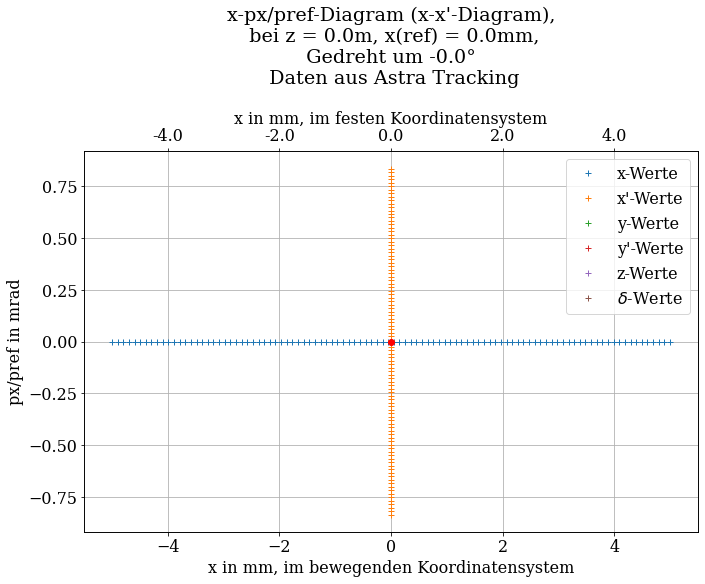

Größeres px --> schnellere Bewegung Richtung x --> größeres x --> ingesamte Drehung von gelb nach rechts


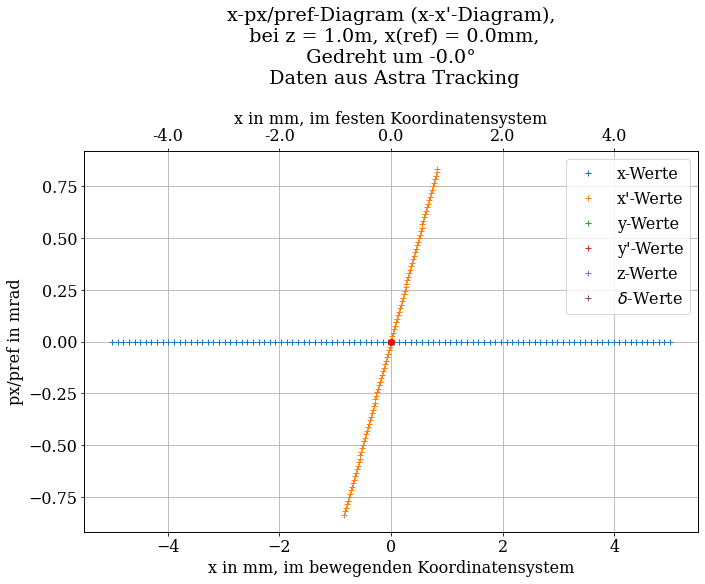

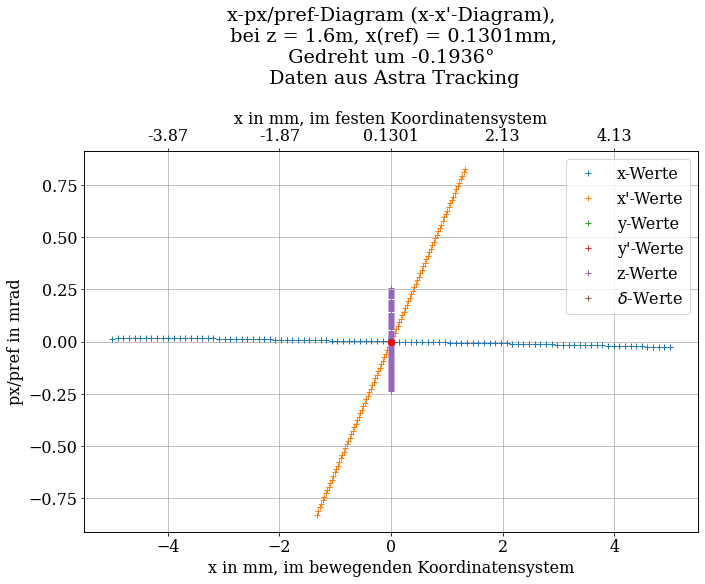

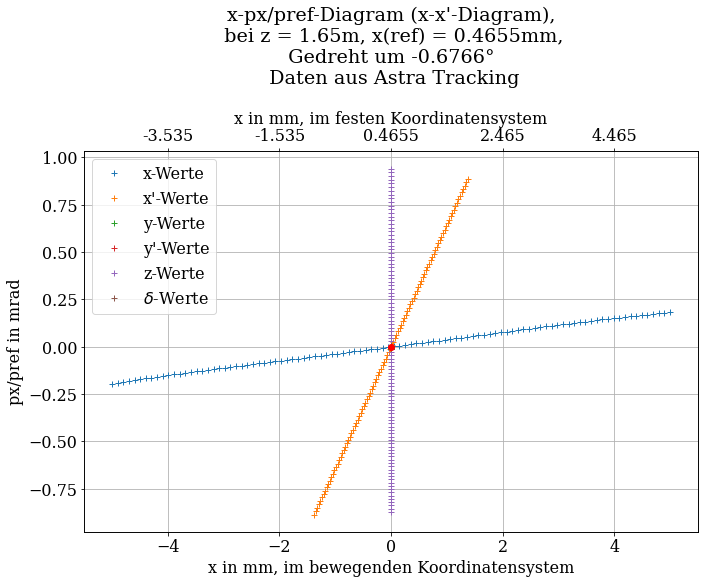

Größeres z --> erreiche früher Dipol --> kriege früher px Impuls --> kriege Verteilung wie im Kreuz
Größeres x --> erreiche wegen Kante früher Dipol --> hörherer px Impuls


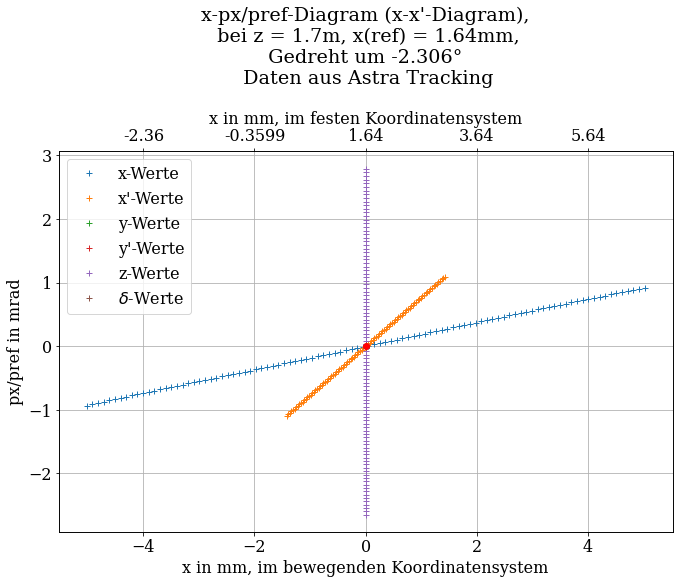

Größeres px --> Drehung von lila nach rechts


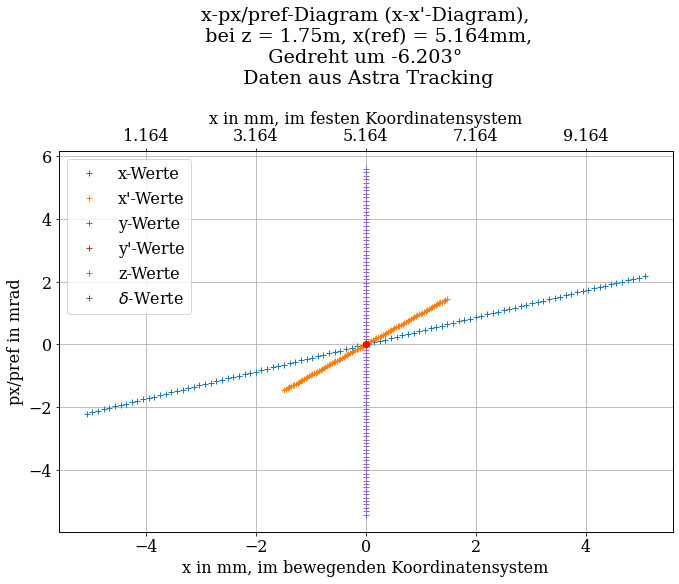

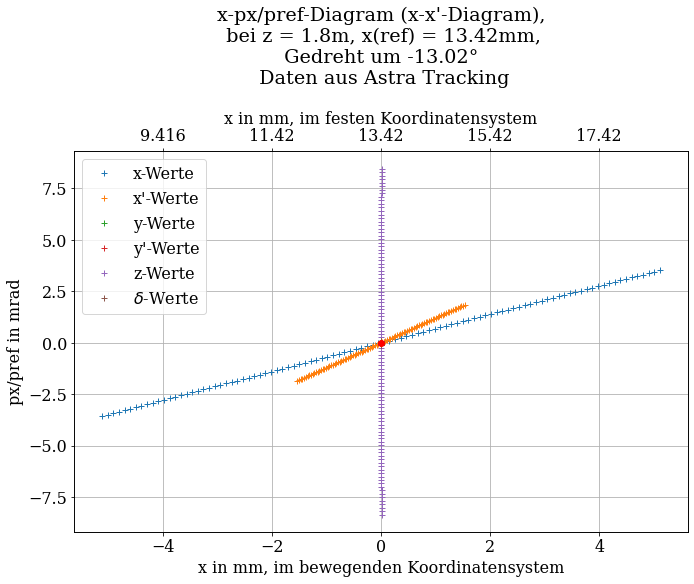

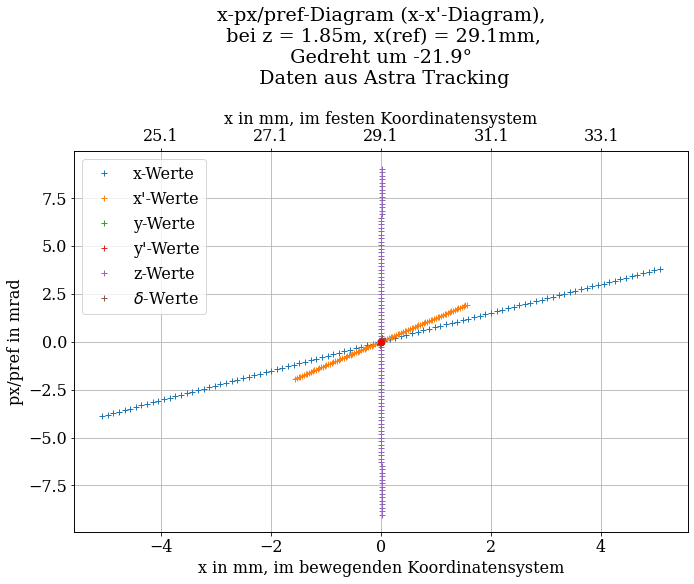

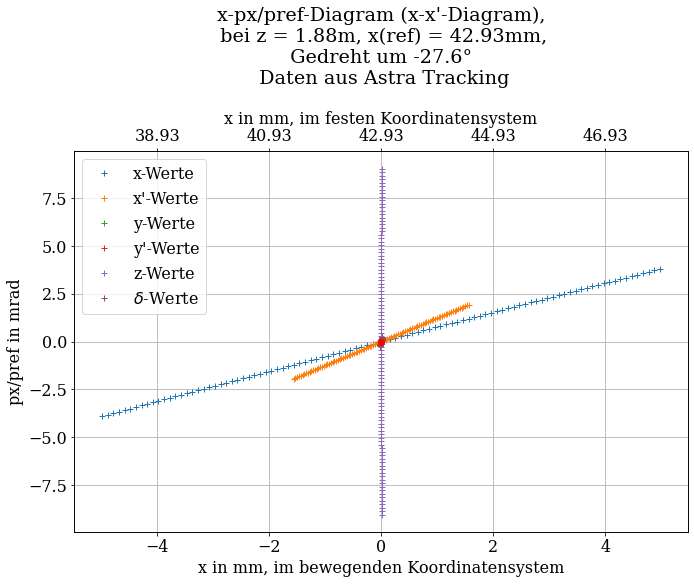

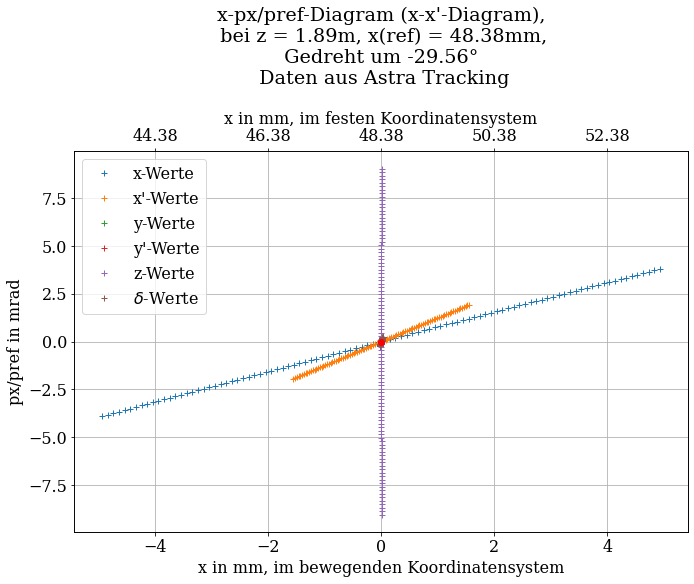

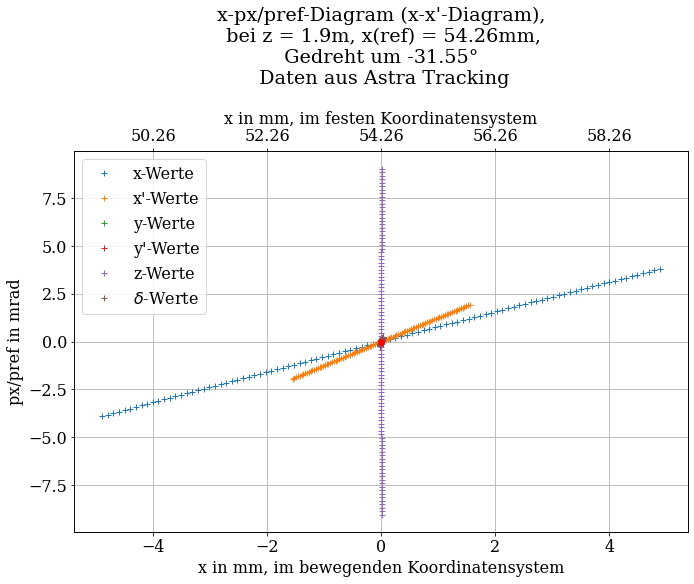

größeres pz --> stärkeres px --> Rechnung wie oben im geschriebenen Teil


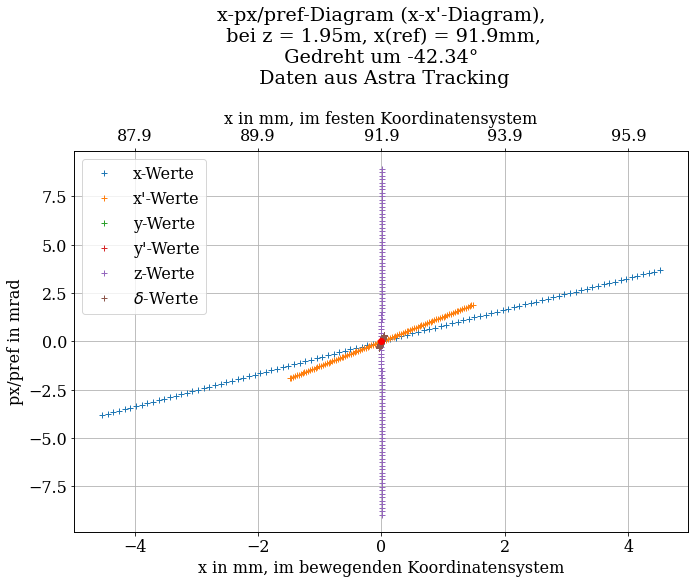

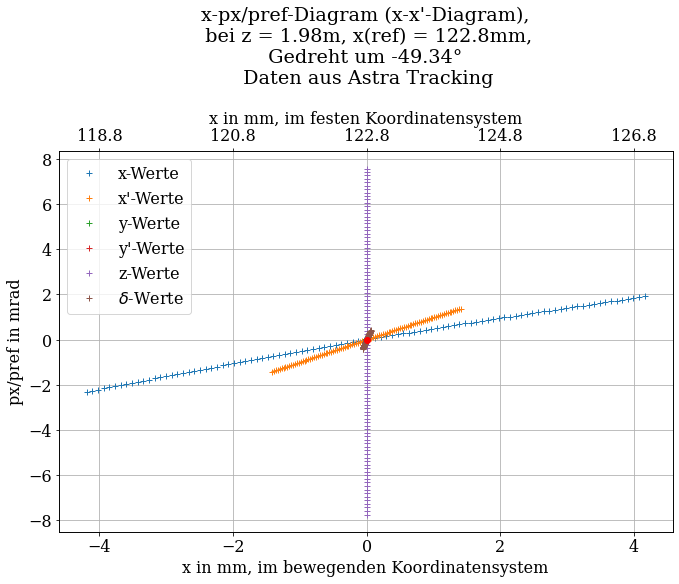

Bei 2m fast aus DIpol raus, sind die mit kleinerem x vielleicht einfach länger im homogenen Bereich? Krigeen stärkeren Kick?


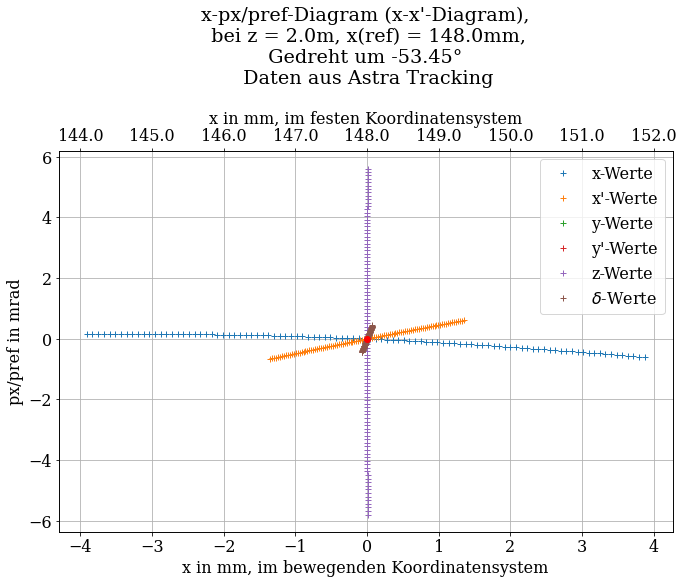

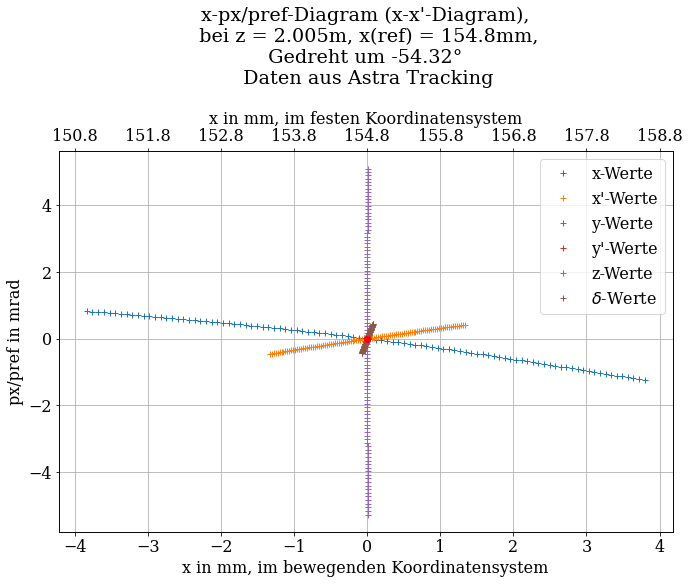

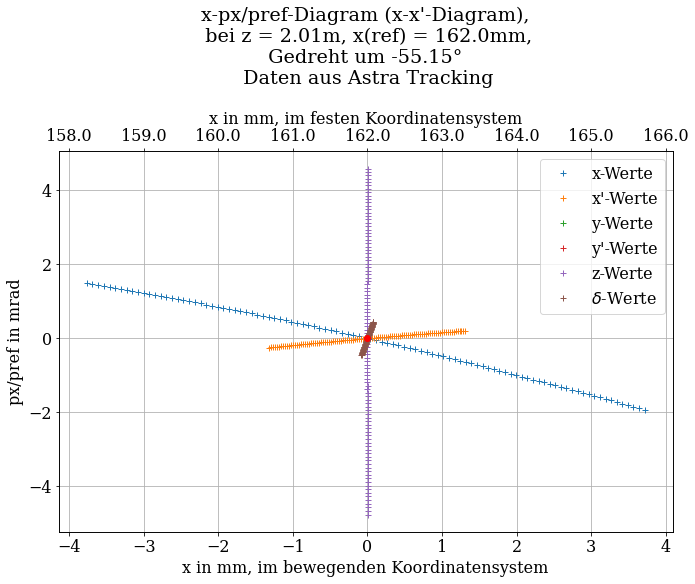

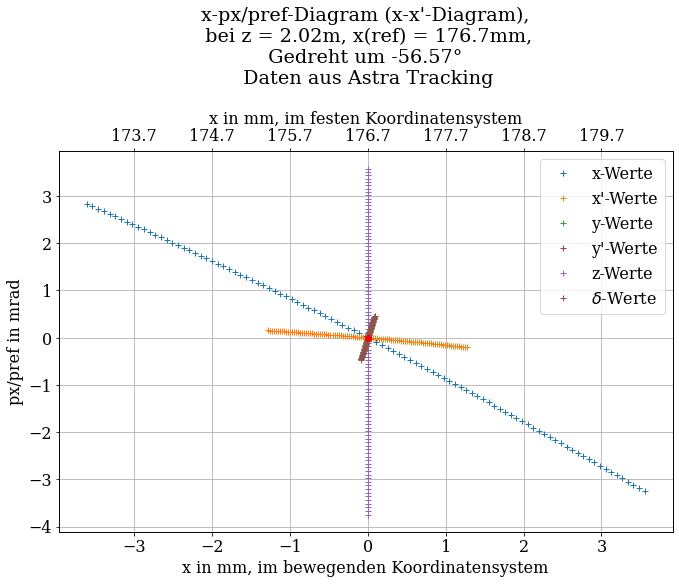

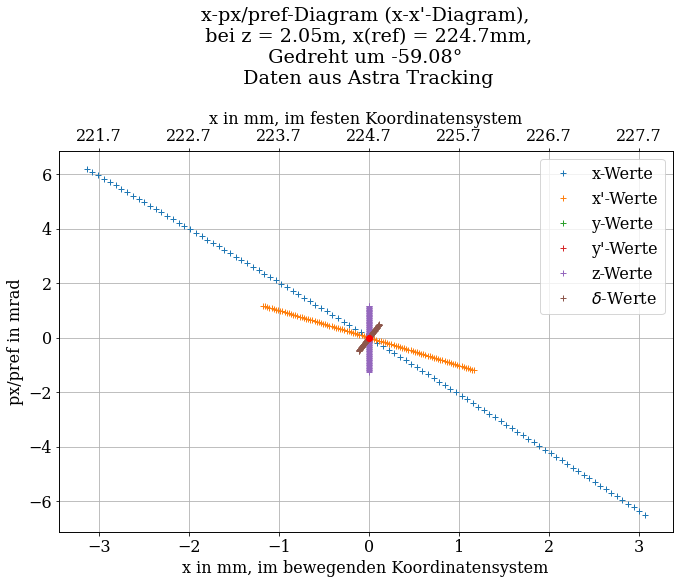

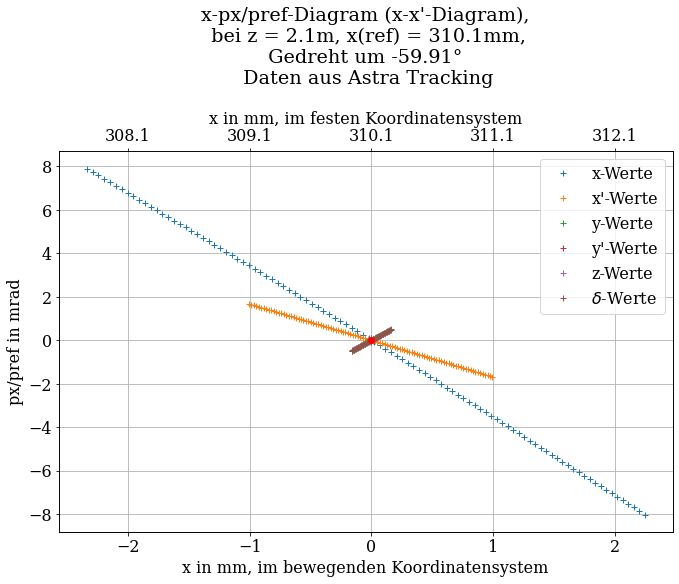

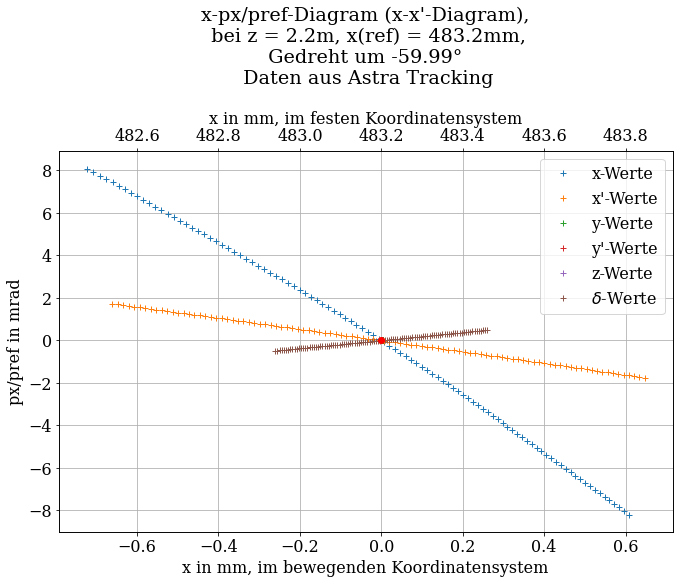

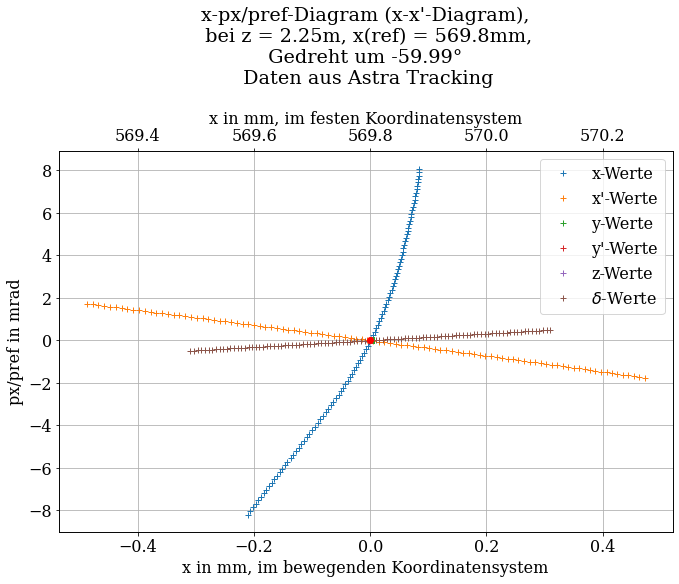

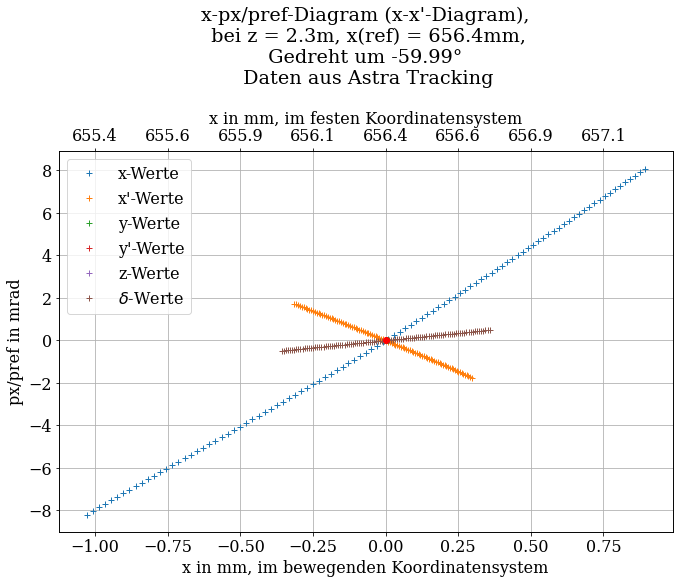

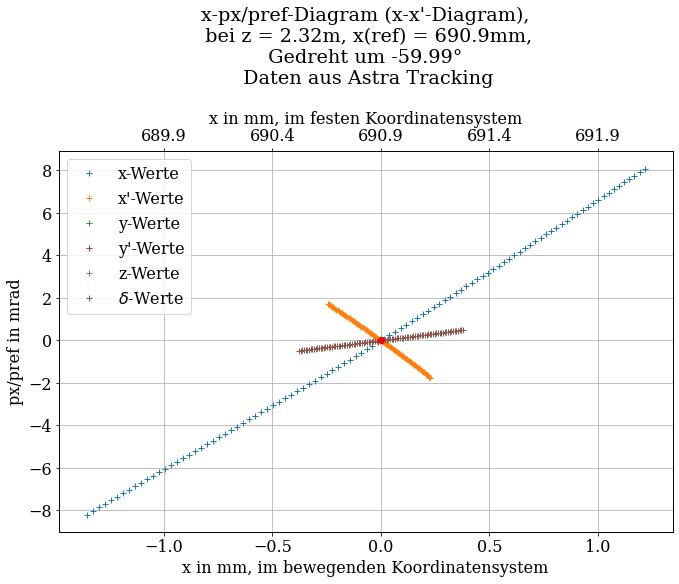

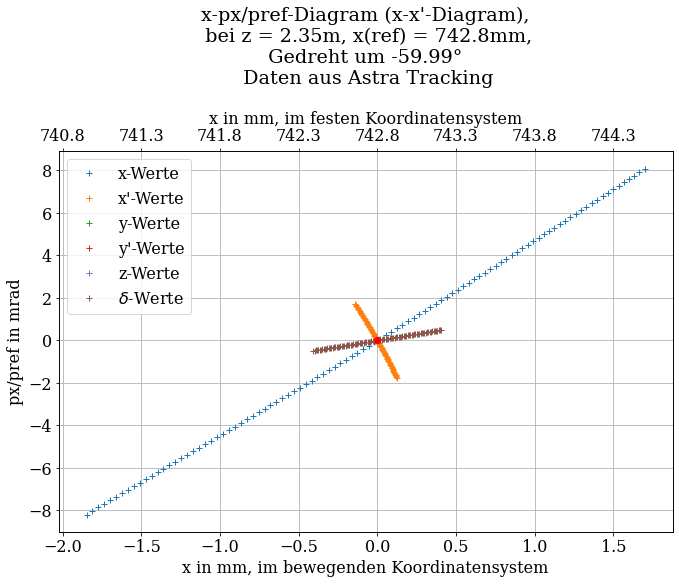

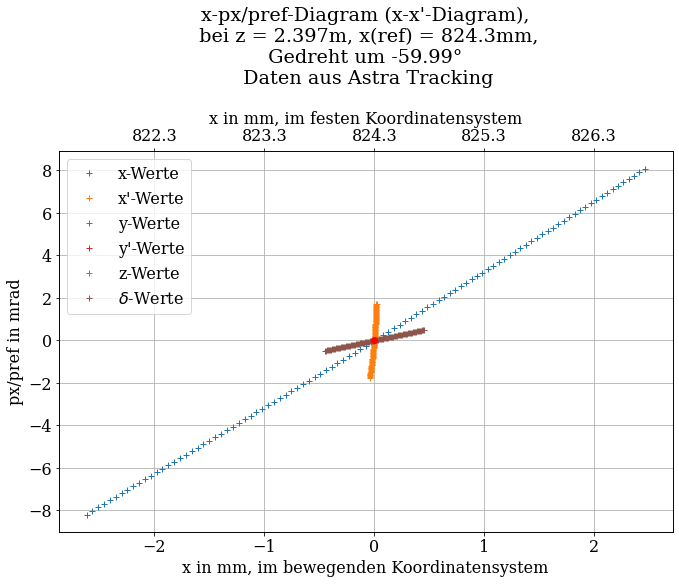

In [53]:
def PlotAnPositionDrehendesSystem(data, **kwargs):
    """
    Das hier dreht sich immer mit. Wir kriegen also ein Bild aus der Perspektive des Referenzteilchens.
    """
    Data = np.transpose(np.genfromtxt(f"{data}"))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
       
    reference = np.transpose(Data)[0]

    length = len(Data[0])
    
    xf = Data[0].copy() 
    
    yf = Data[1].copy() 
    zf = Data[2].copy() 
    zf[1:length] = zf[1:length] + zf[0]
    
    # z Werte waren ja nur relativ zu zRef angegeben. Brauche die natürlich in meinem Bezugssystem!

    # Stimmt das, dass ich die drei Impulse erst einmal einfach so übernehmen kann? Oder muss ich die auch in das System des 
    # Referenzteilchens überführen?
    # Ich lasse es erst einmal so, wie es ist. Das kann ich ja später beides einmal ausprobieren.

    pxf = Data[3].copy() 
    pyf = Data[4].copy() 
    pzf = Data[5].copy()
    pzf[1:length] = pzf[1:length] + pzf[0]
    
    # Will das alles durch das Referenzteilchen teilen. Auch hier muss ich später noch ausprobieren, welcher der initiale Vektor wird
    # mit px, py, pz oder mit x', y', delta?
    preff = pzf[0]
    xSollbahn = np.array([824.5]) / 1000
    zSollbahn = np.array([2397]) / 1000
    
    
    
    # Drehung des ganzen Systems um alpha - alpha wird aus p Vektoren berechnet 
    alpha =- np.arctan(pxf[0]/pzf[0]) 
    DrehMatrix = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]]) # Stelle 2x2 Drehmatrix auf

    Raumkoordinaten = (DrehMatrix @ np.array([zf, xf]))
    Impulskoordinaten = (DrehMatrix @ np.array([pzf, pxf]))
    Sollbahnkoordinaten = (DrehMatrix @ np.array([zSollbahn, xSollbahn]))
    
    
    # Wenn ich jetzt alle koordinaten der Sollbahn hätte, könnte ich diese von den x, z Koordinaten abziehen und würde alles relativ zur SOllbahn statt zum Referenzteilchen bekommen 
    # das wär natürlich deutlich besser
    xSollbahn = Sollbahnkoordinaten[1]
    zSollbahn = Sollbahnkoordinaten[0]
    
    xf = Raumkoordinaten[1]
    zf = Raumkoordinaten[0]

    pxf = Impulskoordinaten[1]
    pzf = Impulskoordinaten[0]
    
    xFestesSystem = Data[0][0]
    zFestesSystem = Data[2][0]
    
    xf = xf - xf[0]
    yf = yf - yf[0]
    zf = zf - zf[0]
    
    xfDash = pxf / pzf 
    yfDash = pyf / pzf
        
    deltaf = (pzf - pzf[0])/ pzf[0]
    
    ax1.plot(xf[1:101] * 1000, xfDash[1:101] * 1000, "+", label = "x-Werte")
    ax1.plot(xf[101:201] * 1000, xfDash[101:201]* 1000, "+", label = "x'-Werte")
    ax1.plot(xf[201:301] * 1000, xfDash[201:301]* 1000, "+", label = "y-Werte")
    ax1.plot(xf[301:401] * 1000, xfDash[301:401]* 1000, "+", label = "y'-Werte")
    ax1.plot(xf[401:501] * 1000, xfDash[401:501]* 1000, "+", label = "z-Werte")
    ax1.plot(xf[501:601] * 1000, xfDash[501:601]* 1000, "+", label = "$\delta$-Werte")
    ax1.plot(xf[0] * 1000, xfDash[0]* 1000, "ro")
    ax1.set_xlabel("x in mm, im bewegenden Koordinatensystem")
    ax1.set_ylabel("px/pref in mrad")
    
    ax2.set_xlabel(r"x in mm, im festen Koordinatensystem")
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xbound(ax1.get_xbound())
    ax2.set_xticklabels([f"{(x / 1000 + reference[0])*1000:.4}" for x in ax1.get_xticks()])
    
    plt.title(f"x-px/pref-Diagram (x-x'-Diagram),\n bei z = {int(data[7:11]) / 1000}m, x(ref) = {xFestesSystem * 1000:.4}mm,\n Gedreht um {alpha* 180 / np.pi :.4}° \n Daten aus Astra Tracking\n")
    ax1.legend()
    ax1.grid()
    
    for key, value in kwargs.items():

        plt.xlim(- value[0], value[0])
        plt.ylim(xfDash[0] * 1000 - value[1], xfDash[0] * 1000 + value[1])
                
    ax2.set_xlabel(r"x in mm, im festen Koordinatensystem")
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xbound(ax1.get_xbound())
    ax2.set_xticklabels([f"{(x / 1000 + xFestesSystem)*1000:.4}" for x in ax1.get_xticks()])
    
    plt.show()


print("Initiales Kreuz mit x und px")
PlotAnPositionDrehendesSystem("Dipole.0000.001")
print("Größeres px --> schnellere Bewegung Richtung x --> größeres x --> ingesamte Drehung von gelb nach rechts")
PlotAnPositionDrehendesSystem("Dipole.1000.001")
PlotAnPositionDrehendesSystem("Dipole.1600.001")
PlotAnPositionDrehendesSystem("Dipole.1650.001")
print("Größeres z --> erreiche früher Dipol --> kriege früher px Impuls --> kriege Verteilung wie im Kreuz")
print("Größeres x --> erreiche wegen Kante früher Dipol --> hörherer px Impuls")
PlotAnPositionDrehendesSystem("Dipole.1700.001")
print("Größeres px --> Drehung von lila nach rechts")
PlotAnPositionDrehendesSystem("Dipole.1750.001")
PlotAnPositionDrehendesSystem("Dipole.1800.001")
PlotAnPositionDrehendesSystem("Dipole.1850.001")
PlotAnPositionDrehendesSystem("Dipole.1880.001")
PlotAnPositionDrehendesSystem("Dipole.1890.001")
PlotAnPositionDrehendesSystem("Dipole.1900.001")
print("größeres pz --> stärkeres px --> Rechnung wie oben im geschriebenen Teil")
PlotAnPositionDrehendesSystem("Dipole.1950.001")
PlotAnPositionDrehendesSystem("Dipole.1980.001")
print("Bei 2m fast aus DIpol raus, sind die mit kleinerem x vielleicht einfach länger im homogenen Bereich? Krigeen stärkeren Kick?")
PlotAnPositionDrehendesSystem("Dipole.2000.001")
PlotAnPositionDrehendesSystem("Dipole.2005.001")
PlotAnPositionDrehendesSystem("Dipole.2010.001")
PlotAnPositionDrehendesSystem("Dipole.2020.001")
PlotAnPositionDrehendesSystem("Dipole.2050.001")
PlotAnPositionDrehendesSystem("Dipole.2100.001")
PlotAnPositionDrehendesSystem("Dipole.2200.001")
PlotAnPositionDrehendesSystem("Dipole.2250.001")
PlotAnPositionDrehendesSystem("Dipole.2300.001")
PlotAnPositionDrehendesSystem("Dipole.2320.001")
PlotAnPositionDrehendesSystem("Dipole.2350.001")
PlotAnPositionDrehendesSystem("Dipole.2397.001")

Was ich jetzt tun möchte: Die Transformationsmatrix für genau diese Bewegung bekommen. Dann habe ich alle Werte für R11 - R66. Diese Matrix fitte ich.

Finale Vektoren.
Die kommen aus der Astra Datei doch schließlich auch als $(x, y, z, px, py, pz)$ heraus. Ich will sie aber als $(x, px, y, py, z, pz)$ haben. Bzw. das ganze mit Dashen.

$(x, x', y, y', z, \delta)$.

Nein. Brauche ich nicht zwingend. Ich muss nur haben, dass die ersten 1:101 mit nur x sind, dann 101:201 nur px ... das habe ich jetzt so oben geändert.

Und, was ich auch möchte: Die x, y, z Werte sollen eigentlich die ganze Zeit in diesem sich mit dem Referenzteilchen bewegenden System sein. Das musste ich bei den initalen Teilchen nicht beachten, weil das Referenzteilchen dort zuerst nur in z-Richtung gegangen ist.

Hier geht das Referenzteilchen am Ende aber in eine Richtung im 60° Winkel von der z-Achse ab. Das muss ich beachten. Auch, dass ich die x und z Werte relativ zum Teilchen brauche.

In [ ]:
#PlotAnPositionDrehendesSystem("Dipole.1600.001")

#-------------- IMPORTIEREN DER FINALEN WERTE --------------
finaleDaten = np.transpose(np.genfromtxt("Dipole.2397.001"))

reference = np.transpose(finaleDaten)[0]
length = len(finaleDaten[0])

xPosScreen = 824.5 #mm
zPosScreen = 2397 #mm

xf = finaleDaten[0].copy() - xPosScreen/ 1000
yf = finaleDaten[1].copy() 
zf = finaleDaten[2].copy() 
zf[1:length] = zf[1:length] + zf[0] - zPosScreen / 1000   # z Werte waren ja nur relativ zu zRef angegeben. Brauche die natürlich in meinem Bezugssystem!
zf[0] =  zf[0] - 2397 / 1000 

xfNoRot = finaleDaten[0].copy()
zfNoRot = finaleDaten[2].copy()

# Stimmt das, dass ich die drei Impulse erst einmal einfach so übernehmen kann? Oder muss ich die auch in das System des 
# Referenzteilchens überführen?
# Ich übernehme das erst einmal in das Referenzteilchensystem. Das kann ich ja später beides einmal ausprobieren.


pxf = finaleDaten[3].copy() 
pyf = finaleDaten[4].copy() 
pzf = finaleDaten[5].copy()
pzf[1:length] = pzf[1:length] + pzf[0]


# Will das alles durch das Referenzteilchen teilen. Auch hier muss ich später noch ausprobieren, welcher der initiale Vektor wird
# mit px, py, pz oder mit x', y', delta?
preff = pzf[0]
xf0 = xf[0]
zf0 = zf[0]

xfDash = pxf / preff
yfDash = pyf / preff
deltaf = (pzf - preff) / preff

# ----------------- DREHUNG ---------------------
alpha =  -60 * np.pi / 180 # Drehung um 60° #- np.arctan(pxf[0]/pzf[0])  # Drehung um Winkel der Teilchen

DrehMatrix = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]]) # Stelle 2x2 Drehmatrix auf
# Beachte, dass y nicht gedreht werden muss. Lediglich x, z Koordinaten ändern sich. 
# Beachte, dass mein x im ursprünglichen System (0, 1) ist und mein z (1, 0) --> Matrix sieht anders aus
# Und px, pz, aber die kann ich jeweils getrennt von einander beachten:

Raumkoordinaten = (DrehMatrix @ np.array([zf, xf]))
Impulskoordinaten = (DrehMatrix @ np.array([pzf, pxf]))
#Dashkoordinaten = (DrehMatrix @ np.array([deltaf, xfDash]))

xf = Raumkoordinaten[1]
zf = Raumkoordinaten[0]

pxf = Impulskoordinaten[1]
pzf = Impulskoordinaten[0]

#xfDash = Dashkoordinaten[1]
#deltaf = Dashkoordinaten[0]

xfDash = pxf / pzf
yfDash = pyf / pzf
deltaf = pzf / pzf[0] 
# relative Abweichung!!!

Das ist die Verteilung, die ich glaube zu brauchen.
Ich habe einen initialen Vektor mit

$(x, px, y, py, z, pz)$, wobei jeweils einhundert Werte um null herum gleichmäßig verteilt liegen.

Außerdem habe ich einen finalen Vektor mit 

$(x, px, y, py, z, pz)$.

Die x, y, z Werte sind alle relativ zum Teilchen und dann gedreht.

In [ ]:
def Reg(x, R, Offset):
    return x * R + Offset

matrixValues = np.zeros(36).reshape(6,6)
umatrixValues = np.zeros(36).reshape(6,6)
matrixGanz = np.empty([6,6], dtype=object) #matri
offsetmatrixValues = np.zeros(36).reshape(6,6)

#vectorInitial = np.array([xi, pxi, yi, pyi, zi, pzi])
vectorInitial = np.array([xi, xiDash, yi, yiDash, zi, deltai])
#vectorFinal = np.array([xf, pxf, yf, pyf, zf, pzf])
vectorFinal = np.array([xf, xfDash, yf, yfDash, zf, deltaf])

for Column in range(6):
    for Row in range(6):
        
        Start = Column * 100 + 1
        End = Column * 100 + 101

       # else:   
        # ich probiere es jetzt mit initial conditions
        #if 0 <= Row <= 1 and 2 <= Column <= 4 or Row == 4 and 2 <= Column <= 3 or 2 <= Row <= 3 and 0 <= Column <= 1 or 2 <= Row <= 3 and 4 <= Column <= 5 or Row == 5 and Column <= 4:
            
        def Reg(x, R, Offset):
            return R * x + Offset
        popt, pcov = scipy.optimize.curve_fit(Reg, vectorInitial[Column][Start:End], vectorFinal[Row][Start:End])
        R, Offset = popt
        uR, uOffset = np.sqrt(np.diag(pcov))
              
            
        # setzte zur Übersicht mal alles kleiner als 10-40 = 0
        if abs(R) < 10e-5:
            matrixValues[Row][Column] = 0 #speichere diese Elemrente in matrixValues
            offsetmatrixValues[Row][Column] = Offset 
            R = 0
            uR = 0
            matrixGanz[Row][Column] = sp.symbols(str(float(roundingDIN(R, uR)[0]))+ '\pm' + str(f"{float(roundingDIN(R, uR)[1]):.5}"))
            print(f"R{Row+1}{Column+1} = {0}")   

        else:    
            matrixValues[Row][Column] = roundingDIN(R, uR)[0] #speichere diese Elemrente in matrixValues
            umatrixValues[Row][Column] = roundingDIN(R, uR)[1]
            matrixGanz[Row][Column] = sp.symbols(str(float(roundingDIN(R, uR)[0]))+ '\pm' + str(f"{float(roundingDIN(R, uR)[1]):.5}"))
            offsetmatrixValues[Row][Column] = Offset 
            print(f"R{Row+1}{Column+1} = {roundingDIN(R, uR)[0]} +- {roundingDIN(R, uR)[1]}")  
            
            

Wenn ich mir den Offset hier anschaue, dann ist der letzte Wert höufig ein Ausreißer. Warum?  Spielt keine Rolle, das Ergebnis ändert sich kaum mit oder ohne.

Vielleicht addiere ich den Offset falsch?

#### Offset

Woher kommt der offset?

Wenn ich diese linearen Geraden fitte, dann sollte ich natürlich mx+n nutzen, statt mx. Ansonsten fehlt der Ordinatenabschnitt, das verfälscht das Ergebnis. 

Beachten muss ich das ganze dann, indem ich ich diesen Offset einfach an meine finalen Daten heran addiere. ODER?


In [ ]:
xfNoRot[0]

In [ ]:
xOffset = np.mean(offsetmatrixValues[0])
xDashOffset = np.mean(offsetmatrixValues[1])
yOffset = np.mean(offsetmatrixValues[2])
yDashOffset = np.mean(offsetmatrixValues[3])
zOffset = np.mean(offsetmatrixValues[4])
deltaOffset = np.mean(offsetmatrixValues[5])

finalerVektor = matrixValues @ vectorInitial

xfFit = finalerVektor[0] + xOffset
xfDashFit = finalerVektor[1] + xDashOffset
yfFit = finalerVektor[2] + yOffset
yfDashFit = finalerVektor[3] + yDashOffset
zfFit = finalerVektor[4] + zOffset
deltafFit = finalerVektor[5] + deltaOffset

pref = deltafFit[0]

Ref = xfFit[0]


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
    
#plt.plot(xfFit[0] * 1000, xfDashFit[0] * 1000, "ro")
ax1.plot((xfFit[1:101]) * 1000, xfDashFit[1:101] * 1000, "+", label = "x-Werte")
ax1.plot((xfFit[101:201]) * 1000, xfDashFit[101:201] * 1000, "+", label = "x'-Werte")
ax1.plot((xfFit[201:301] ) * 1000, xfDashFit[201:301] * 1000, "+", label = "y-Werte")
ax1.plot((xfFit[301:401]) * 1000, xfDashFit[301:401] * 1000, "+", label = "y'-Werte")
ax1.plot((xfFit[401:501] ) * 1000, xfDashFit[401:501] * 1000, "+", label = "z-Werte")
ax1.plot((xfFit[501:601] ) * 1000, xfDashFit[501:601] * 1000, "+", label = "delta-Werte")
ax1.legend()
ax1.grid()
ax1.set_xlabel("$x$ in mm, in screen coordinate system")
ax1.set_ylabel("$p_x/p_{ref}$ in mrad")

ax2.set_xlabel(r"$x$ in mm, in fixed coordinate system")
ax2.set_xticks(ax1.get_xticks())
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels([f"{(xfNoRot[0]*1000 + x / 1000):.4}" for x in ax1.get_xticks()])

plt.title("$x-p_x/p_{ref}$-Diagram ($x-x'$-Diagram) (3D Field),\n at $z$ = " + str( '%.4f'%zfNoRot[0]) + " m, $x_{ref}$ =  "+ str('%.4f'%xfNoRot[0]) + " m in fixed system,\n Data from fitted transformation matrix\n")
    
plt.show()

PlotAnPositionDrehendesSystem("Dipole.2397.001")

plotTheo(finalerVektorTheo)
print("Die x-Werte sind ungefähr rihtig verteilt. Die px Werte liegen ungefähr richtig, sind nur nciht groß genug. Gleiches mit pz. Die y Werte sind alle nicht drauf, weil ich von einer richtigen Entkoppelung ausgehe.")

Werte alle negativ, weil x bei mir nach oben definiert ist - negatives R16 gibt negative x ablage, stimmt aber hier -
Matrix gibt x Werte "nach außen". Inzwischen niht mehr. Theoretische Matrix habe ich umdefiniert.

In [ ]:
print(sp.Matrix(matrixValues[:2, :2]))
test = str(float(.4309))+'+- 0.006'


sp.Matrix([sp.symbols(test)])

In [ ]:
umatrixValues

In [ ]:
print("Aus Astra gefittete Matrix:")
display(sp.Matrix(matrixValues))
print("Sanity Check: Determinante muss 1 sein.")
print(f"det(M) = {sp.Matrix(matrixValues).det()}")
print("Uncertainties:")
display(sp.Matrix(umatrixValues))
print("")
print("Combined matrix:")
display(sp.Matrix(matrixGanz))
print("")

print("Theoretisch errechnete Matrix:")
display(TrafoMatrix)
print("Sanity Check: Determinante muss 1 sein.")
print(f"det(M) = {TrafoMatrix.det()}")

In [ ]:
np.array(umatrixValues)

Dann: $ \sigma_S = \sqrt{R_{11}^2 \sigma_{x,i}^2 + 2 R_{11} R_{12} \sigma_{x, x', i}^2 + R_{12}^2 \sigma_{x', i}^2 + R_{16}^2 \delta^2}$

$\sigma_S$ ist erste Standardabweichung (66%) auf dem Schirm. 
$\sigma_{x}$ entsprechend in $x$ Richtung, $\sigma_{x'}$ entsprechend in $x'$ Richtung, jeweils $i$ für initial.


Kriege dann, wenn $R_{11}$, $R_{12}$ klein genug sind:

\begin{align}
x_f &= R_{11} x + R_{12} x' + R_{16} \delta \\
x_f &\approx R_{16} \delta \\
\delta &= \frac{x_f}{R_{16}}
\end{align}

with $\delta = \frac{p-p_0}{p_0}$

\begin{align}
p &= p_0 \cdot (\frac{x_f}{R_{16}}+1) \\
\Rightarrow \; \Delta p &= p_0 \cdot (\frac{\sigma_S }{R_{16}}+1)
\end{align}

Allerdings sind hier R12 und R11 nicht klein genug. Was mit dieser Rechnung herauskommt:

In [ ]:
R16Fit = matrixValues[0][5]
R16Theo = np.array(np.array(TrafoMatrix)[0][5])
xfMin = min(xf)
xfMax = max(xf)
#sigmax = +- xfMax - xfMin

print("xfMin, mm", xfMin * 1000 )#mm
print("xfMax, mm", xfMax * 1000 )#mm

p0 = 6 
up0 = 0
uR16 = umatrixValues[0][5]
xmin = xfMin
xmax = xfMax
R16 = R16Fit
def p(xmin = xmin, uxmin = 0, xmax = xmax, uxmax = 0, R16 = R16, uR16 = 0, p0 = p0, up0 = 0):
    
    #up = np.sqrt((p0 / R16 * usigma)**2 + (- sigma/R16**2 * p0 * uR16)**2 + ((sigma / R16 +1)*up0)**2)
    p = p0 * ((xmin)/R16 - (xmax)/R16)
    
    return p

p = p0 * ((xfMin)/R16Fit - (xfMax)/R16Fit )

print("Deltap, fit, keV", p*1000)


pTheo = p0 * ((xfMin/R16Theo +1) - (xfMax/R16Theo +1))
print("Deltap, Theo, keV", pTheo*1000)

In [ ]:
xfMax - xfMin

Man muss also die ersten beiden Elemente noch kleiner bekommen. 

Will also die R's kleiner bekommen und die $\sigma$'s. Dafür: Schlitz - aber ist schwierig einzubauen in Vakuumröhre.

Habe aber Quadrupole. Rechne Transfermatrix mit QP aus.

$ M * -(L_0 + Leff) * QP * L_0$ - da ich Strecke vor QP (L0) gehe, dann QP Matrix. Dann muss ich wieder auf meinen ursprünglichen Ort zurück, damit ich dann meine schon vorher bekommene Matrix ranmultiplizieren kann.

In [ ]:
k, LQP, L0 = sp.symbols('k, L_QP, L_0')

In [ ]:
LQP = 0.1368 #m
L0 = 0.2023 - LQP/2 # Position ist Center, aber will nur die Driftstrecke vorher haben

In [ ]:
Quadrupole  = sp.Matrix([[sp.cos(sp.sqrt(k) * LQP),  sp.sin(sp.sqrt(k) * LQP) / sp.sqrt(k) , 0, 0, 0, 0],
                  [-sp.sqrt(k) * sp.sin(sp.sqrt(k) * LQP), sp.cos(sp.sqrt(k) * LQP),  0, 0, 0, 0],
                  [0, 0, sp.cosh(sp.sqrt(k) * LQP), sp.sinh(sp.sqrt(k) * LQP) / sp.sqrt(k), 0, 0],
                  [0, 0, sp.sqrt(k) *  sp.sinh(sp.sqrt(k) * LQP), sp.cosh(sp.sqrt(k) * LQP), 0, 0],
                  [0, 0, 0, 0, 1, LQP / gamma**2],
                  [0, 0, 0, 0, 0, 1]])

DriftNull = sp.Matrix([[1, L0, 0, 0, 0, 0], 
                   [0, 1, 0, 0, 0, 0], 
                   [0, 0, 1, L0, 0, 0], 
                   [0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, L0/(gamma**2)], 
                   [0, 0, 0, 0, 0, 1]])

DriftNullPlusEff = sp.Matrix([[1, L0 + LQP, 0, 0, 0, 0], 
                   [0, 1, 0, 0, 0, 0], 
                   [0, 0, 1, L0+ LQP, 0, 0], 
                   [0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, (L0+ LQP)/(gamma**2)], 
                   [0, 0, 0, 0, 0, 1]])

In [ ]:
Quadrupole

In [ ]:
R11 = []
R12 = []
R16 = []


# gehe jetzt viele ks durch, um zu schauen, wo R11 und R12 am kleinsten werden (Absolutwerte von ihnen)
kList = np.linspace(-300.1, 600, 100)

for i in kList:
    k = i

    Quadrupole  = sp.Matrix([[sp.cos(sp.sqrt(k) * LQP),  sp.sin(sp.sqrt(k) * LQP) / sp.sqrt(k) , 0, 0, 0, 0],
                  [-sp.sqrt(k) * sp.sin(sp.sqrt(k) * LQP), sp.cos(sp.sqrt(k) * LQP),  0, 0, 0, 0],
                  [0, 0, sp.cosh(sp.sqrt(k) * LQP), sp.sinh(sp.sqrt(k) * LQP) / sp.sqrt(k), 0, 0],
                  [0, 0, sp.sqrt(k) *  sp.sinh(sp.sqrt(k) * LQP), sp.cosh(sp.sqrt(k) * LQP), 0, 0],
                  [0, 0, 0, 0, 1, LQP / gamma**2],
                  [0, 0, 0, 0, 0, 1]])
    
    Matrix = matrixValues * (-DriftNullPlusEff) * Quadrupole * DriftNull
    R11.append(np.array(Matrix)[0][0])
    R12.append(np.array(Matrix)[0][1])
    R16.append(np.array(Matrix)[0][5])

    
plt.plot(kList, R11, "+", label = "R11")
plt.plot(kList, R12, "+", label = "R12")
plt.plot(kList, R16, "+", label = "R16")
plt.legend()
plt.xlabel("k in $m^{-2}$")
plt.ylabel("$R_{1i}$")
plt.title("$R_{1i}$ vs. k")

Bei welchem Wert von k werden R11, R12 besonders klein? Diese möchte ich bei den QP in Realität einstellen, dann kann ich mit R16 weiterrechnen wie oben beschrieben.

In [ ]:
index = np.where(abs(np.array(R11)) == min(abs(np.array(R11))))
k = kList[index][0]

print("k =", k)

Quadrupole  = sp.Matrix([[sp.cos(sp.sqrt(k) * LQP),  sp.sin(sp.sqrt(k) * LQP) / sp.sqrt(k) , 0, 0, 0, 0],
                  [-sp.sqrt(k) * sp.sin(sp.sqrt(k) * LQP), sp.cos(sp.sqrt(k) * LQP),  0, 0, 0, 0],
                  [0, 0, sp.cosh(sp.sqrt(k) * LQP), sp.sinh(sp.sqrt(k) * LQP) / sp.sqrt(k), 0, 0],
                  [0, 0, sp.sqrt(k) *  sp.sinh(sp.sqrt(k) * LQP), sp.cosh(sp.sqrt(k) * LQP), 0, 0],
                  [0, 0, 0, 0, 1, LQP / gamma**2],
                  [0, 0, 0, 0, 0, 1]])

Matrix = matrixValues * DriftNullPlusEff * Quadrupole * DriftNull
print("Gefittet mit QP:")
display(sp.Matrix(Matrix))

plt.plot(kList[index][0], np.array(R11)[index][0], "ro", label = "min(|R11|)")  
plt.plot(kList, R11, "+", label = "R11")
plt.plot(kList, R12, "+", label = "R12")
plt.plot(kList, R16, "+", label = "R16")
plt.legend()
plt.xlabel("k in $m^{-2}$")
plt.ylabel("$R_{1i}$")
plt.title("$R_{1i}$ vs. k")

In [ ]:
index = np.where(abs(np.array(R11)- np.array(R12)) == min(abs(np.array(R11)- np.array(R12))))
k = kList[index][0]

print("k =", k)

Quadrupole  = sp.Matrix([[sp.cos(sp.sqrt(k) * LQP),  sp.sin(sp.sqrt(k) * LQP) / sp.sqrt(k) , 0, 0, 0, 0],
                  [-sp.sqrt(k) * sp.sin(sp.sqrt(k) * LQP), sp.cos(sp.sqrt(k) * LQP),  0, 0, 0, 0],
                  [0, 0, sp.cosh(sp.sqrt(k) * LQP), sp.sinh(sp.sqrt(k) * LQP) / sp.sqrt(k), 0, 0],
                  [0, 0, sp.sqrt(k) *  sp.sinh(sp.sqrt(k) * LQP), sp.cosh(sp.sqrt(k) * LQP), 0, 0],
                  [0, 0, 0, 0, 1, LQP / gamma**2],
                  [0, 0, 0, 0, 0, 1]])

Matrix = matrixValues * DriftNullPlusEff * Quadrupole * DriftNull
print("Gefittet mit QP:")
display(sp.Matrix(Matrix))

plt.plot(kList[index][0], np.array(R11)[index][0], "ro", label = "min(|R11 - R12|)")  
plt.plot(kList, R11, "+", label = "R11")
plt.plot(kList, R12, "+", label = "R12")
plt.plot(kList, R16, "+", label = "R16")
plt.legend()
plt.xlabel("k in $m^{-2}$")
plt.ylabel("$R_{1i}$")
plt.title("$R_{1i}$ vs. k")
plt.show()

In [ ]:
finalerVektor[0]

In [ ]:
finalerVektor = np.array(Matrix) @ vectorInitial

xfFit = finalerVektor[0] + xOffset
xfDashFit = finalerVektor[1] + xDashOffset
yfFit = finalerVektor[2] + yOffset
yfDashFit = finalerVektor[3] + yDashOffset
zfFit = finalerVektor[4] + zOffset
deltafFit = finalerVektor[5] + deltaOffset

pref = deltafFit[0]

Ref = xfFit[0]


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
    
#plt.plot(xfFit[0] * 1000, xfDashFit[0] * 1000, "ro")
ax1.plot((xfFit[1:101]) * 1000, xfDashFit[1:101] * 1000, "+", label = "x-Werte")
ax1.plot((xfFit[101:201]) * 1000, xfDashFit[101:201] * 1000, "+", label = "x'-Werte")
ax1.plot((xfFit[201:301] ) * 1000, xfDashFit[201:301] * 1000, "+", label = "y-Werte")
ax1.plot((xfFit[301:401]) * 1000, xfDashFit[301:401] * 1000, "+", label = "y'-Werte")
ax1.plot((xfFit[401:501] ) * 1000, xfDashFit[401:501] * 1000, "+", label = "z-Werte")
ax1.plot((xfFit[501:601] ) * 1000, xfDashFit[501:601] * 1000, "+", label = "delta-Werte")
ax1.legend()
ax1.grid()
ax1.set_xlabel("x in mm, in moving coordinate system")
ax1.set_ylabel("px/pref in mrad")
plt.title(f"x-px/pref-Diagram (x-x'-Diagram) (3D Field),\n at z = {zf0:.4}m, x(ref) = {xf0 * 1000:.4}mm in fixed system,\n Data from fitted transformation matrix\n")
    


ax2.set_xlabel(r"x in mm, in fixed coordinate system")
ax2.set_xticks(ax1.get_xticks())
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels([f"{(xf0 + x / 1000) * 1000:.4}" for x in ax1.get_xticks()])



plt.show()


In [ ]:
R16Fit = np.array(Matrix)[0][5]
xfMin = min(xf)
xfMax = max(xf)

print("xfMin, mm", xfMin * 1000 )#mm
print("xfMax, mm", xfMax * 1000 )#mm

p0 = 6 

p = p0 * ((xfMin/R16Fit +1) - (xfMax/R16Fit +1))
print("Deltap, fit, keV", p*1000)

In [ ]:
def EnergySpread(xfMin, xfMax, p0):
    R16Fit = np.array(Matrix)[0][5]
    pMax = p0 * (xfMax/R16 +1)
    pMin = p0 * (xfMin/R16 +1)
    
    deltap = pMax-pMin
    return deltap

In [ ]:
np.array(Matrix)